# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

# Imports

In [185]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

In [186]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH, list_datasets
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [188]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [189]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)
print(list_datasets(context))

['/raw/housing', '/cleaned/housing', '/train/housing/features', '/train/housing/target', '/test/housing/features', '/test/housing/target', '/score/sales/output']


# Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## Read the Train and Test Data

In [190]:
train_X = load_dataset(context, "train/housing/features")
train_y = load_dataset(context, "train/housing/target")
print(
    f"""
    train_X_shape->{train_X.shape}
    train_y_shape->{train_y.shape}
    """
)


test_X = load_dataset(context, "test/housing/features")
test_y = load_dataset(context, "test/housing/target")
print(
    f"""
    test_X_shape->{test_X.shape}
    test_y_shape->{test_y.shape}
    """
)


    train_X_shape->(16512, 9)
    train_y_shape->(16512, 1)
    

    test_X_shape->(4128, 9)
    test_y_shape->(4128, 1)
    


## Feature Engineering Pipelines

**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [191]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [192]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(16512, 9)
(16512, 9)


#### Encoding


Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

In [193]:
# NOTE: the list of transformations here are not sequential but weighted 
# (if multiple transforms are specified for a particular column)
# for sequential transforms use a pipeline as shown above.
features_transformer = ColumnTransformer([
    ## categorical columns
    ('tgt_enc', OneHotEncoder(), list(cat_columns)),

    ## numeric columns
    ('med_enc', SimpleImputer(strategy='median'), num_columns),  
])

In [194]:
features_transformer

ColumnTransformer(transformers=[('tgt_enc', OneHotEncoder(),
                                 ['ocean_proximity']),
                                ('med_enc', SimpleImputer(strategy='median'),
                                 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object'))])

**Dev notes(Encoding):**
<details>

    Some common practices followed in Categorical Feature Encoding are
    * For categorical variables with too many levels, target encoding can be done.
    * For fewer levels, one hot encoding can be done.
    * If one very dominant level is observed, binary encoding can be used.
    
    
</details>

## 3.2 Feature analysis

Using the pipeline above analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

In [195]:
sample_X = train_X.sample(frac=0.1, random_state=context.random_seed)
sample_y = train_y.loc[sample_X.index]

sample_train_X = get_dataframe(
    features_transformer.fit_transform(sample_X, sample_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

# nothing to do for target
sample_train_y = sample_y

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Running the features transformer on the complete data

In [196]:
train_X = get_dataframe(
    features_transformer.fit_transform(train_X, train_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [197]:
cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income']
out = eda.get_density_plots(train_X, cols=cols)
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [longitude]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [198]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

In [199]:
reports.feature_analysis(train_X,'./feature_analysis_report.html')

Error: Must have equal len keys and value when setting with an iterable

### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [200]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,households,total_bedrooms,0.973557,0.973557
1,latitude,longitude,-0.924918,0.924918
2,total_bedrooms,total_rooms,0.919087,0.919087
3,households,total_rooms,0.913502,0.913502
4,households,population,0.907971,0.907971
5,population,total_bedrooms,0.873697,0.873697
6,population,total_rooms,0.844430,0.844430
7,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,-0.606939,0.606939


In [201]:
%%time
# create reports as needed
cols = train_X.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

CPU times: user 18.9 s, sys: 20.9 s, total: 39.8 s
Wall time: 15 s


In [202]:
reports.feature_interactions(train_X,'./feature_interaction_report.html')

this method is deprecated in favour of `Styler.to_html()`


### 3.2.3 Key Drivers - Interaction with Target variable

In [203]:
out = eda.get_target_correlation(train_X, train_y)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')
    [1] HoloViews(Bars, name='mutual_information')

In [204]:
curated_cols = get_feature_names_from_column_transformer(features_transformer)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [205]:
# saving the list of relevant columns
save_pipeline(curated_cols, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [206]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [207]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

### 4.1.2 Data transformations

In [208]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [209]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f6a521b9040>,
                                     kw_args={'cols2keep': ['ocean_proximity_INLAND',
                                                            'ocean_proximity_ISLAND',
                                                            'ocean_proximity_NEAR '
                                                            'BAY',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'housing_median_age',
                                                            'total_bedrooms',
                                                            'population',
                                                            'median_income']})),
                ('estimator', SKLStatsmodelOLS())])

In [210]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     3820.
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:02:11   Log-Likelihood:            -2.0725e+05
No. Observations:               16512   AIC:                         4.145e+05
Df Residuals:                   16503   BIC:                         4.146e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                   1.144e+04   2714.443      4.213      0.000    6116.164    1.68e+04
ocean_proximity_INLAND     -6.977e+04   1324.516    -52.676      0.000   -7.24e+04   -6.72e+04
ocean_proximity_ISLAND      1.745e+05   3.42e+04      5.100      0.000    1.07e+05    2.42e+05
ocean_proximity_NEAR BAY     155.2281   1851.316      0.084      0.933   -3473.551    3784.007
ocean_proximity_NEAR OCEAN  1.164e+04   1689.109      6.893      0.000    8332.727     1.5e+04
housing_median_age          1386.4367     48.890     28.358      0.000    1290.606    1482.267
total_bedrooms               145.9692      3.228     45.221      0.000     139.642     152.296
population                   -46.8183      1.203    -38.923      0.000     -49.176     -44.461
median_income                 4.3e+04    321.380    133.804      0.000    4.24e+04    4.36e+04
==============================================================================
Omnibus:                     3612.350   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10299.115
Skew:                           1.152   Prob(JB):                         0.00
Kurtosis:                       6.109   Cond. No.                     1.14e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [211]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])

test_X = get_dataframe(
    features_transformer.fit_transform(test_X), 
    get_feature_names_from_column_transformer(features_transformer)
)
test_X = test_X[curated_cols]

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [212]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
Attribute `_pairwise` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
this method is deprecated in favour of `Styler.to_html()`


**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [213]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [214]:
residual_analysis

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,prediction,actuals,forecast_flag
0,0.0,0.0,0.0,0.0,1.0,-124.15,40.78,36.0,2112.0,374.0,829.0,368.0,3.3984,234909.437166,90000.0,over predict
1,1.0,0.0,0.0,0.0,0.0,-122.80,38.39,26.0,2273.0,474.0,1124.0,420.0,2.9453,190702.914546,166700.0,good
2,1.0,0.0,0.0,0.0,0.0,-117.80,33.77,29.0,5436.0,707.0,2046.0,685.0,8.7496,435301.849450,349500.0,good
3,1.0,0.0,0.0,0.0,0.0,-118.87,34.23,14.0,4242.0,746.0,1858.0,689.0,6.0145,311385.749102,287100.0,good
4,0.0,1.0,0.0,0.0,0.0,-119.37,36.19,24.0,1306.0,266.0,889.0,276.0,2.4922,79316.022975,66100.0,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,0.0,1.0,0.0,0.0,0.0,-120.72,37.54,17.0,729.0,134.0,431.0,121.0,4.2188,146032.705620,131300.0,good
4124,1.0,0.0,0.0,0.0,0.0,-118.32,33.98,49.0,1993.0,446.0,1052.0,394.0,2.2138,190418.931628,119800.0,over predict
4125,1.0,0.0,0.0,0.0,0.0,-118.24,34.13,37.0,1644.0,395.0,959.0,383.0,3.3636,220134.820373,257700.0,good
4126,0.0,1.0,0.0,0.0,0.0,-119.03,36.08,19.0,2471.0,431.0,1040.0,426.0,3.2500,121985.951586,80600.0,over predict


In [215]:
residual_analysis.hvplot.kde(y="median_income",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="median_income",
                                title=f'median income(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [median_income]   (Density)

- From the above plot we can infer that the higher "over predictions" are happening for unit_cost > 200.
- similarly, the higher "under predictions" are happening for unit_cost is zero.

This can help us tune the model by a separate model for unit_cost > 200


# 4.2 Modelling - XGBoost

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [224]:
train_X.rename(columns={"ocean_proximity_<1H OCEAN": "ocean_proximity_1H OCEAN"}, inplace=True)

In [226]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

### 4.2.3 Model Tuning

<AxesSubplot:>

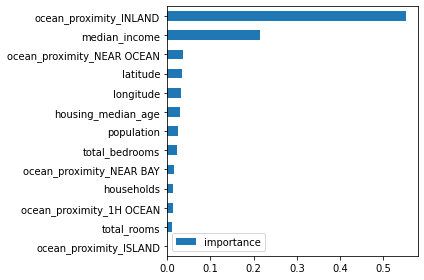

In [227]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

##### Pipeline build based on new importance features

In [230]:
# let's find features for some decent defaults
imp_features = ["housing_median_age", "longitude", "latitude", "ocean_proximity_NEAR OCEAN", "median_income", "ocean_proximity_INLAND"]

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', XGBRegressor())
])

#### Grid Search of the Estimator

In [231]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


0.8109304076386892
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 27.3 s, sys: 43.2 ms, total: 27.4 s
Wall time: 6.63 s


#### Pipeline Build using the best estimator

In [232]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f6a521b9040>,
                                     kw_args={'cols2keep': ['housing_median_age',
                                                            'longitude',
                                                            'latitude',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'median_income',
                                                            'ocean_proximity_INLAND']})),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0.03, gpu_id=-1,
                              importance_type='gain',
                              interaction_const

In [233]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
Attribute `_pairwise` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
this method is deprecated in favour of `Styler.to_html()`


# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [250]:
model_comparison_report.performance_metrics

metric,MAPE,WMAPE,MAE,RMSE,R^2
", Linear Regression",0.2906,0.2417,49964.7758,68376.2531,0.6493
", XGBoost",0.1770,0.1542,31870.3345,46521.2903,0.8377


**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges

In this example we are choosing LM model for pipelining. General criteria for choosing production models is:

- Parametric models (aka whitebox models) such as Linear Regression are easier to explain to non-technical audience.
- Generally these are accepted fast and adoption is quicker.
- If the downstream calls for optimization using these models parametric models are easier to implement.
- When accuracy is primary goal without explainability, the above two takes a backseat